# Figure - Scenarios

May 4, 2022, updated May 12, 2022


### Scenario 1 - Updating M during learning

Here we use weight mirroring to update $M$ during learning of $W^{rec}$

### Scenario 2 - Learning _only_ $W^{fb}$

Here I update the flow field metric slightly to account for possible learning due to feedback. After many simulations and a sweep across hyperparameters, I have found it hard to distinguish M from Wbmi1. This is in part due to the fact that networks learning Wfb alonge perform poorly if Wbmi0 and Wbmi1 are very different, and if M and Wbmi1 are very different (i.e. less than 0.75)

In [1]:
folder = 'figures-2022-5-12/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator,FixedFormatter
import matplotlib.pylab as pylab

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import interpolate # don't import stats
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy
import pickle

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars
from algorithms.weight_mirror import WeightMirror

from utils.plotting import plot_trained_trajectories, paper_format
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


### Train RNN on four targets

Note here that the input is only "on" for 20% of the trial.

In [4]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

# Part 1 - RFLO across multiple seeds, Scenarios where M is learned

In [ ]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.05,eta_out=0.1,eta_m=0.001,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,sig_m = 0.1, lam_m = 0.00001,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
seeds = [1]#,5,7]#,1,12,54,72,81]
overlaps = [0.4]
n_changes = [75]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corrcoef'] = []

stats['covariance1'] = []
stats['covariance2'] = []
stats['covariance3'] = []

stats['corr_w_m'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corrcoef_list = []
    
    covariance1_list = []
    covariance2_list = []
    covariance3_list = []
    
    corr_w_m = []

    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """
        """ Calculate F fields Over windows """
        window = 200
        delta = 600
        blocks = np.arange(0,1500,window)
        
        for start in blocks:
            end = start + delta + window
            print('start {} end {} '.format(start,end))
            if end+window > np.max(blocks):
                break
                
                
            net1_pre = RNN(params)
            net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net1.w_rec.copy())
            net1_pre.set_weights(w_out = w_out1)
            net1_pre.set_weights(w_m = net1.w_m.copy()) # make sure this is updated!

            sim1_pre = Simulation(net1_pre)
            trackvars = TrackVars(net1_pre,apply_to=[]) 
            sim1_pre.run_session(n_trials=window, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
            #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

            """ Train with new decoder """

            sim1_train = Simulation(net1)
            rflo = RFLO(net1,apply_to=['w_rec'],online=False)
            weight_mirror = WeightMirror(net1,apply_to=['w_m']) 
            print('>>APPLY WEIGHT MIRRORING')
            sim1_train.run_session(n_trials=delta, tasks=[task1,task2,task3,task4], learn_alg=[rflo,weight_mirror], probe_types=['h','loss','err'], plot=True, plot_freq=10)

            """ Track activity with new decoder, after training """
            net1_post = RNN(params)
            net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy())
            net1_post.set_weights(w_out = net1.w_out.copy())
            net1_post.set_weights(w_m = net1.w_m.copy())

            sim1_post = Simulation(net1_post)
            trackvars = TrackVars(net1_post,apply_to=[]) 
            sim1_post.run_session(n_trials=window, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
            
            fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

            fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')

        
        
            F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
            F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

            print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

            Fdata = F_late - F_early

            # separate train and test data from sim1_train
            n_total = len(sim1_train.session_probes['h'])
            n_train = int(0.5 * n_total)
            idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
            idx_test = np.arange(0,n_total)[~idx_train].astype(int)
            #idx_test=idx_train

            h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
            err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

            Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
            Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
            Fpred_w_m = flow_field_predicted(net1.w_m.T,err_train,h_train)

            h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

            corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
            corr1_list.append(corr1)

            corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
            corr2_list.append(corr2)

            corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
            corr3_list.append(corr3)
            
            
            """ keep tack of alignment """
            
            corr_w_m.append(np.corrcoef(net1.w_m.copy().T.ravel(),net1.w_out.copy().ravel())[0,1])

            fig,ax = plt.subplots(1,1)
            plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])
            plt.ylim([0,1])
            plt.ylabel('correlation')
            plt.title('Alignment Wout Wm={:.3f}'.format(corr_w_m[-1]))
            plt.show()
        

        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    
    stats['corr_w_m'].append(corr_w_m)



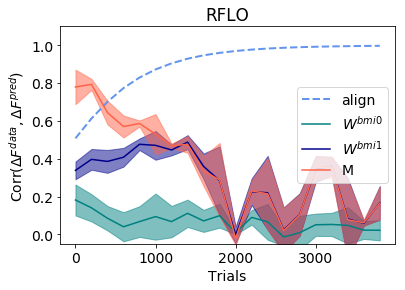

In [34]:
save = False
paper = False

ind = np.where(blocks < blocks[-1]-window-delta)[0]
x = blocks[ind]

mn1 = np.mean(np.asarray(stats['corr1']).T,axis=1)
mn2 = np.mean(np.asarray(stats['corr2']).T,axis=1)
mn3 = np.mean(np.asarray(stats['corr3']).T,axis=1)
std1 = np.std(np.asarray(stats['corr1']).T,axis=1)
std2 = np.std(np.asarray(stats['corr2']).T,axis=1)
std3 = np.std(np.asarray(stats['corr3']).T,axis=1)

fig,ax = plt.subplots(1,1)

plt.plot(x,np.mean(np.asarray(stats['corr_w_m']).T,axis=1),'--',linewidth=2,color='cornflowerblue',label='align')

plt.plot(x,mn1,'-',color='teal',label=r'$W^{bmi0}$')
plt.plot(x,mn2,'-',color='darkblue',label=r'$W^{bmi1}$')
plt.plot(x,mn3,'-',color='tomato',label='M')
plt.fill_between(x,mn1-std1,mn1+std1,alpha=0.5,color='teal')
plt.fill_between(x,mn2-std2,mn2+std2,alpha=0.5,color='darkblue')
plt.fill_between(x,mn3-std3,mn3+std3,alpha=0.5,color='tomato')



plt.title('RFLO')
plt.ylabel('Corr('+r'$\Delta F^{data},\Delta F^{pred})$')
plt.xlabel('Trials')
plt.ylim([-0.05,1.1])
#plt.xlim([-50,1400])
plt.legend()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.2,0.4,0.6,0.8,1],linewidth=2,ylim=[-0.05,1],figsize=(2.25,3))

plt.show()

if save:
    fig.savefig(folder+'rflo-weight-mirror.pdf')

# Part 2 - RFLO across multiple seeds, Scenarios where Wfb alone is learned

In [5]:
def flow_field_predicted(W,err_list,h_list,feedback=False,decoder=None):
    
    """ Prediction change in flow field due to learning
    
    Args
    ----
    W (np.array): matrix used to calculate flow field based on learning
    err_list: list of np.arrays, each item is err for a trial
    h_list: list of np.arrays, each item is h for a trial
    feedback (bool): wether to alter calculation slightly if considering upstream circuit
    decoder (np.array): known decoder, used for altered metric calculated with upstream circuit in mind
    
    TO DO: Maybe consider alternative learning rule updates here?
    """
    
    n_steps = h_list[0].squeeze().shape[0]
    n_neurons = h_list[0].squeeze().shape[1]
    
    dF = np.zeros((n_neurons,n_neurons))
    
    if feedback:
        assert decoder is not None, 'must specify decoder output W_out'
    
    # loop through trials
    for trial in range(len(h_list)):
        
        # loop through timesteps
        for t in range(n_steps):
            
            # this assumes cumulative weight update
            if not feedback:
                dF += np.outer(W.T @ err_list[trial].squeeze()[t], h_list[trial].squeeze()[t]) # should this be previous time step?
            if feedback:
                dF += np.outer(W.T @ err_list[trial].squeeze()[t], decoder @ h_list[trial].squeeze()[t]) @ decoder

            
    return dF

In [184]:
trial=1
t= 2
a = np.outer(w_out1.T @ err_train[trial].squeeze()[t], pos_train[trial].squeeze()[t]) @ w_out1 @ h_train[trial].squeeze()[t]
a.shape

(50,)

In [6]:
trial_duration = 20
n_in=4
frac_on = 1
print('>FRACTION ON {}'.format(frac_on))

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

>FRACTION ON 1


2it [00:00, 18.20it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.1
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2
driving_feedback: True
eta_fb: 0.5
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fbbf3fb85e8>



12it [00:00, 118.89it/s]

FEEDBACK FLOWFIELD CALCULATION
M norm: 0.89	 M angle: 0.79, 7 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.80
w_m norm: 0.89	 w_out1 vs. w_m angle: 0.79
w_m norm: 1.29	 w_out vs. w_m angle: 0.65

500it [00:04, 115.75it/s]
5000it [00:53, 93.85it/s]
500it [00:04, 121.28it/s]


AR early fit 0.979, late fit 0.982


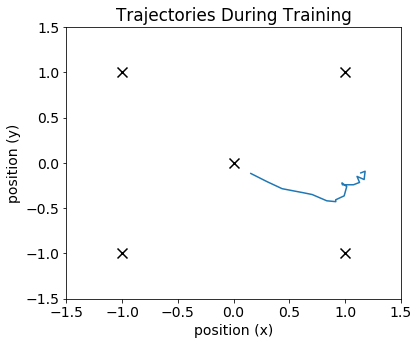

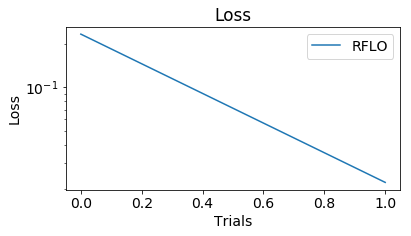

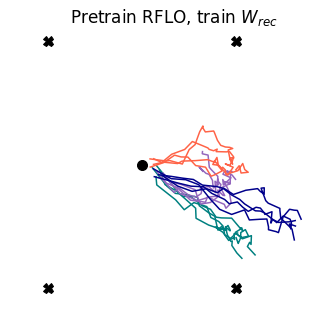

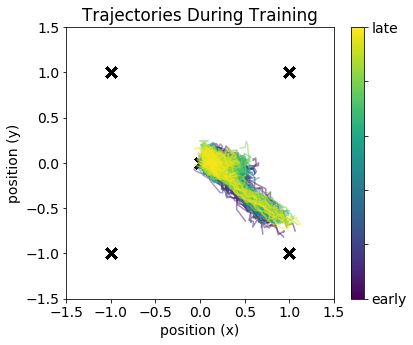

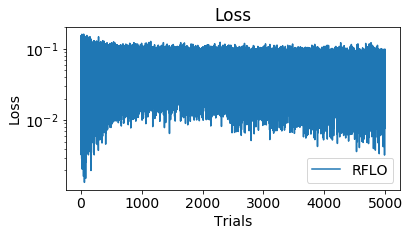

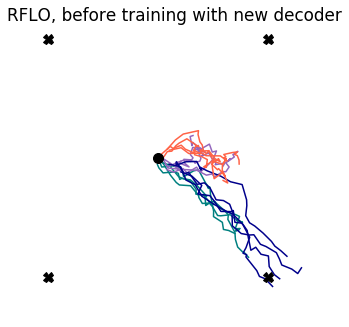

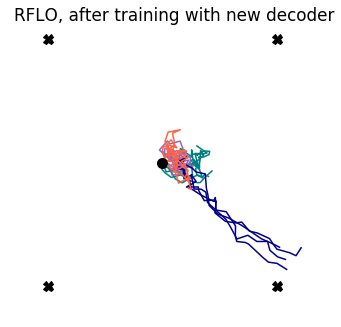

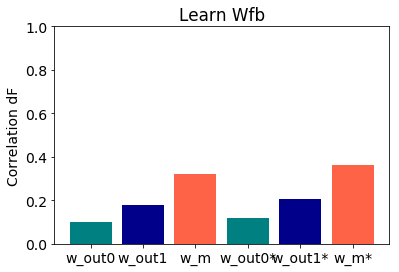

11it [00:00, 103.07it/s]

M norm: 0.91	 M angle: 0.80, 4 iterations
w_out1 norm: 1.03	 w_out vs. w_out1 angle: 0.79
w_m norm: 0.91	 w_out1 vs. w_m angle: 0.80
w_m norm: 1.24	 w_out vs. w_m angle: 0.68

500it [00:04, 123.08it/s]
5000it [00:51, 97.21it/s]
500it [00:04, 121.28it/s]


AR early fit 0.979, late fit 0.981


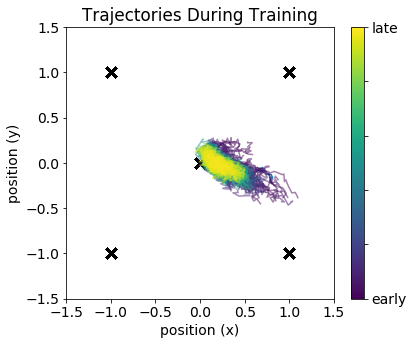

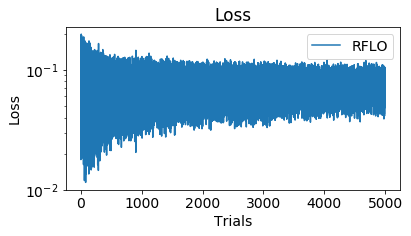

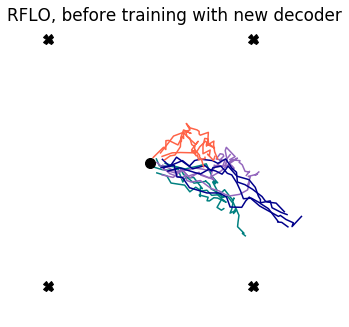

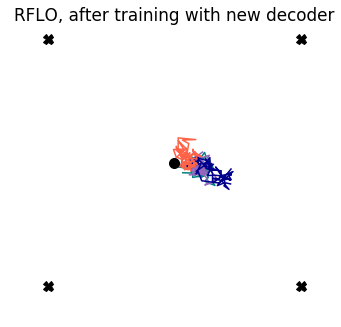

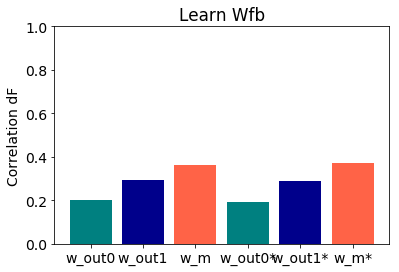

10it [00:00, 99.14it/s]

M norm: 0.93	 M angle: 0.79, 8 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.80
w_m norm: 0.93	 w_out1 vs. w_m angle: 0.79
w_m norm: 1.34	 w_out vs. w_m angle: 0.63

500it [00:04, 122.74it/s]
5000it [00:51, 96.68it/s]
500it [00:04, 123.65it/s]


AR early fit 0.979, late fit 0.980


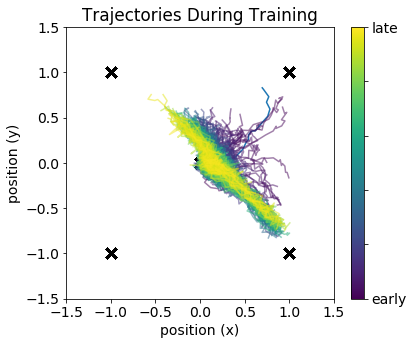

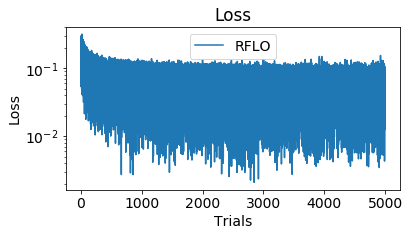

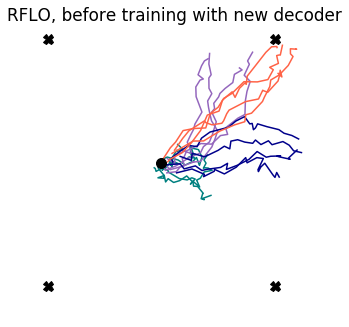

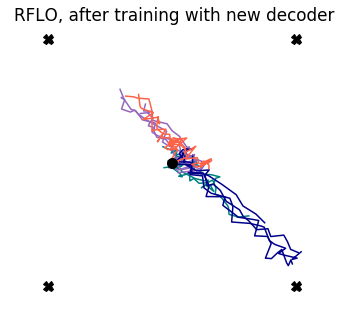

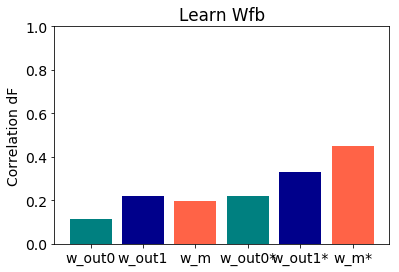

10it [00:00, 97.06it/s]

M norm: 0.91	 M angle: 0.81, 11 iterations
w_out1 norm: 1.04	 w_out vs. w_out1 angle: 0.79
w_m norm: 0.91	 w_out1 vs. w_m angle: 0.81
w_m norm: 1.34	 w_out vs. w_m angle: 0.62

500it [00:04, 123.31it/s]
5000it [00:51, 96.33it/s]
500it [00:04, 124.49it/s]


AR early fit 0.979, late fit 0.981


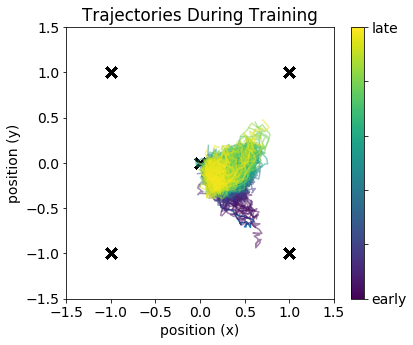

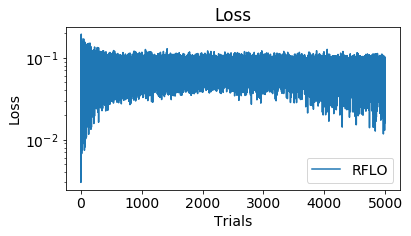

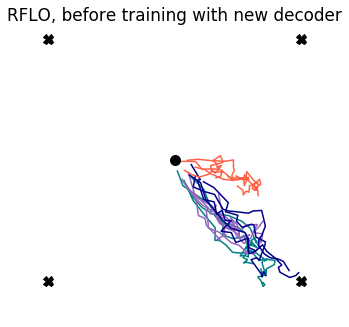

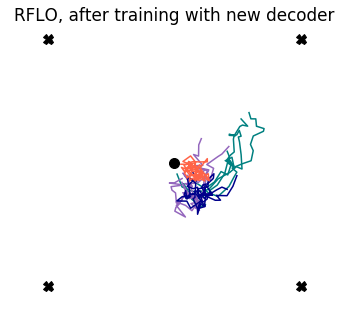

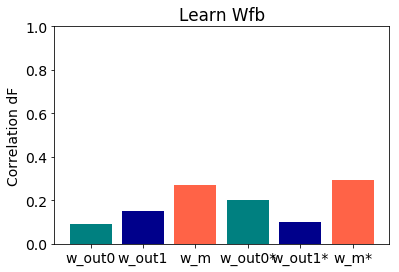

8it [00:00, 75.96it/s]

M norm: 0.87	 M angle: 0.80, 4 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.80
w_m norm: 0.87	 w_out1 vs. w_m angle: 0.80
w_m norm: 1.31	 w_out vs. w_m angle: 0.63

500it [00:05, 97.90it/s] 
5000it [01:02, 80.01it/s]
500it [00:04, 115.45it/s]


AR early fit 0.979, late fit 0.981


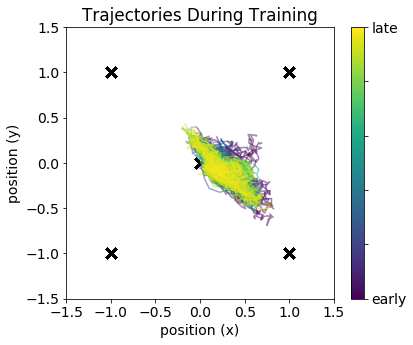

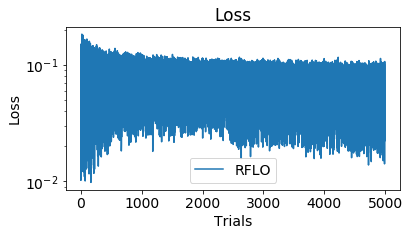

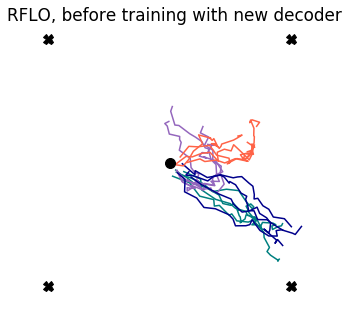

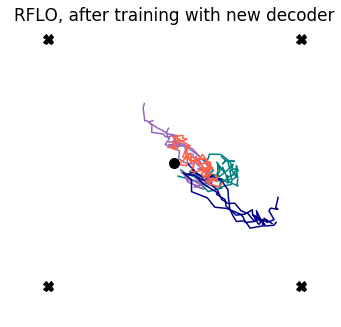

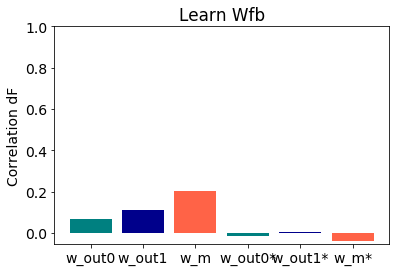

11it [00:00, 105.49it/s]

M norm: 0.94	 M angle: 0.79, 1 iterations
w_out1 norm: 1.01	 w_out vs. w_out1 angle: 0.80
w_m norm: 0.94	 w_out1 vs. w_m angle: 0.79
w_m norm: 1.27	 w_out vs. w_m angle: 0.67

500it [00:04, 122.43it/s]
5000it [00:52, 74.28it/s]
500it [00:04, 116.67it/s]


AR early fit 0.979, late fit 0.984


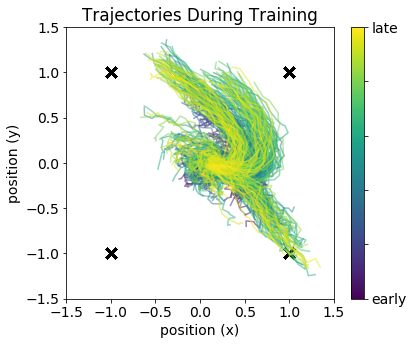

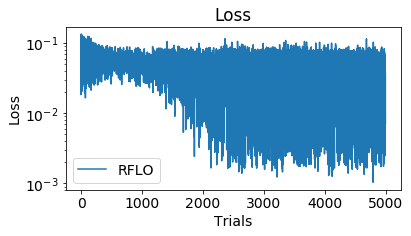

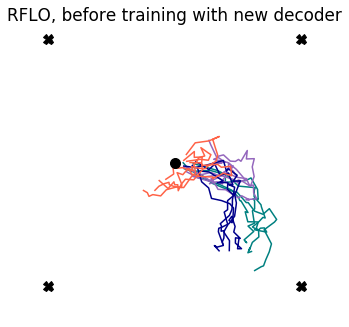

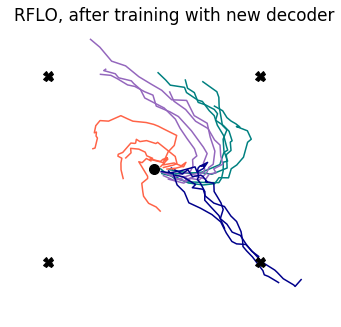

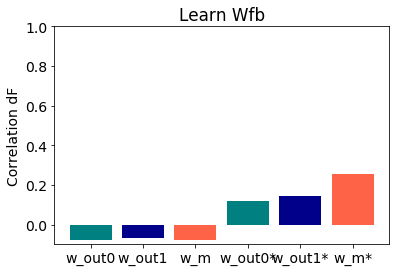

11it [00:00, 109.50it/s]

M norm: 0.93	 M angle: 0.79, 1 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.81
w_m norm: 0.93	 w_out1 vs. w_m angle: 0.79
w_m norm: 1.30	 w_out vs. w_m angle: 0.64

500it [00:04, 123.30it/s]
5000it [00:52, 95.31it/s]
500it [00:04, 118.97it/s]


AR early fit 0.979, late fit 0.982


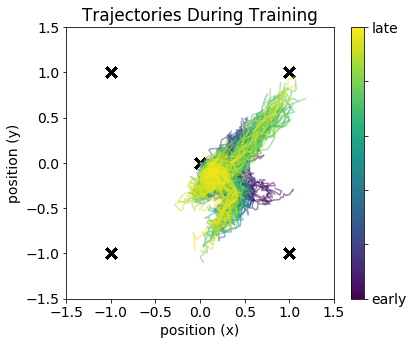

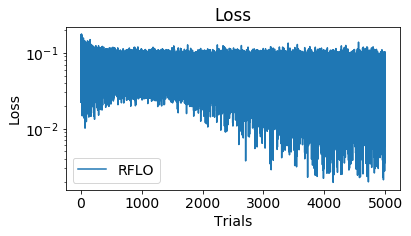

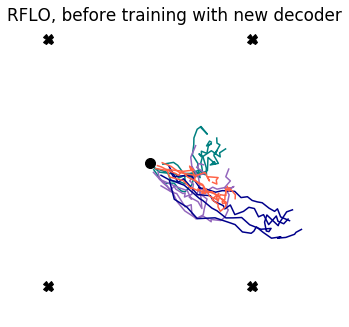

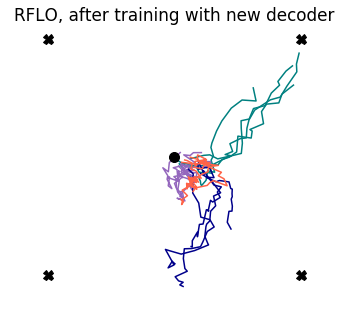

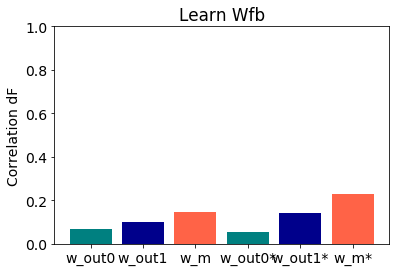

11it [00:00, 107.24it/s]

M norm: 0.91	 M angle: 0.80, 13 iterations
w_out1 norm: 1.03	 w_out vs. w_out1 angle: 0.79
w_m norm: 0.91	 w_out1 vs. w_m angle: 0.80
w_m norm: 1.35	 w_out vs. w_m angle: 0.61

500it [00:04, 122.63it/s]
5000it [00:52, 95.88it/s]
500it [00:04, 123.89it/s]


AR early fit 0.979, late fit 0.981


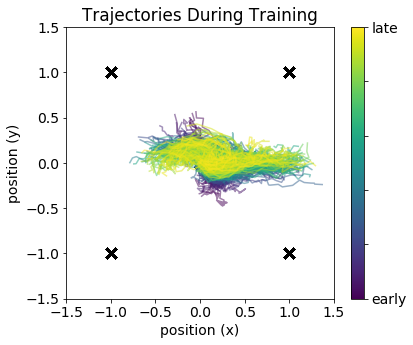

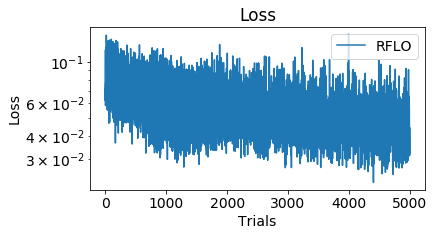

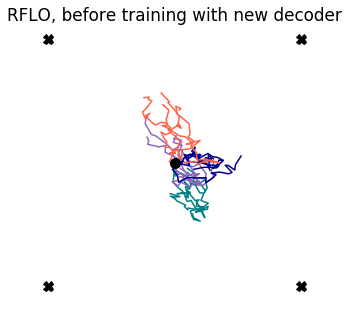

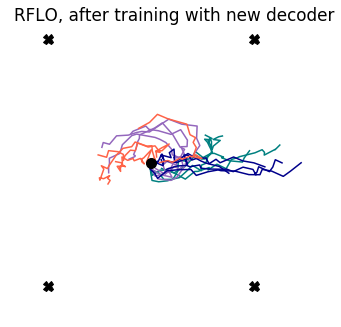

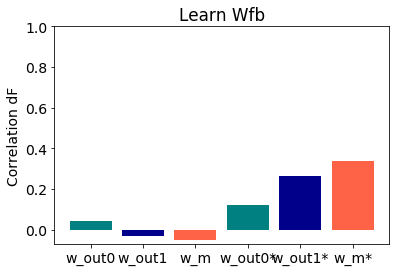

8it [00:00, 77.61it/s]

M norm: 0.93	 M angle: 0.81, 20 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.81
w_m norm: 0.93	 w_out1 vs. w_m angle: 0.81
w_m norm: 1.28	 w_out vs. w_m angle: 0.66

500it [00:05, 95.99it/s]
629it [00:08, 75.51it/s]


KeyboardInterrupt: 

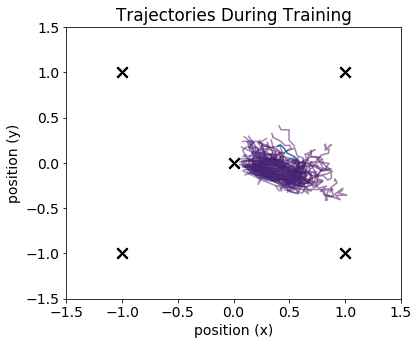

In [7]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,g_fb=2,
               sig_in=0.0,sig_rec=0.1,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec','w_fb'],online=False)
sim0.run_session(n_trials=2000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
#seeds = [0,1,12,54] #,72,81]
seeds = [32,33,47,91,73,444,567,886,212]#,72,81,1973,1978,2002]
overlaps = [0.8]
overlap_w_out0 = 0.8
n_changes_w_out0 = 25
n_changes = [25]
training_duration = 5000

feedback_calculation = True
if feedback_calculation:
    print('FEEDBACK FLOWFIELD CALCULATION')

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = []
stats['corr5'] = []
stats['corr6'] = []
stats['corrcoef'] = []

stats['corr_w_fb_w_m'] = []
stats['corr_w_fb_w_out'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corr5_list = []
    corr6_list = []
    corrcoef_list = []
    
    corr_w_fb_w_m = []
    corr_w_fb_w_out = []

    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_changes_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        
        corr_w_fb_w_m.append(np.corrcoef(net1_pre.w_fb.copy().ravel(),net1_pre.w_m.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)
        corr_w_fb_w_out.append(np.corrcoef(net1_pre.w_fb.copy().ravel(),net1_pre.w_out.T.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)

        
        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_fb'],online=False)
        sim1_train.run_session(n_trials=training_duration, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err','pos'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy(),w_fb = net1.w_fb.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]
        pos_train = np.asarray(sim1_train.session_probes['pos'])[idx_train,:,:,:]

        
        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        
        if feedback_calculation:
            """ Take feedback into account with variation of metric """
            Fpred_w_out_fb = flow_field_predicted(net0.w_out,err_train,h_train,feedback=True,decoder=w_out1)
            Fpred_w_out1_fb = flow_field_predicted(w_out1,err_train,h_train,feedback=True,decoder=w_out1)
            Fpred_w_m_fb = flow_field_predicted(w_m,err_train,h_train,feedback=True,decoder=w_out1)

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        if feedback_calculation:
            """ Take feedback into account with variation of metric """
            corr4 = calculate_flow_field_correlation(Fpred_w_out_fb,Fdata,h_test) # could also sample sim_test
            corr4_list.append(corr4)

            corr5 = calculate_flow_field_correlation(Fpred_w_out1_fb,Fdata,h_test) # could also sample sim_test
            corr5_list.append(corr5)

            corr6 = calculate_flow_field_correlation(Fpred_w_m_fb,Fdata,h_test) # could also sample sim_test
            corr6_list.append(corr6)
        
        # correlation after learning
        corr_w_fb_w_m.append(np.corrcoef(net1.w_fb.copy().ravel(),net1.w_m.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)
        corr_w_fb_w_out.append(np.corrcoef(net1.w_fb.copy().ravel(),net1.w_out.T.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)

        
        fig,ax = plt.subplots(1,1)
        if feedback_calculation:
            plt.bar([0,1,2,3,4,5],[corr1,corr2,corr3,corr4,corr5,corr6],tick_label=['w_out0','w_out1','w_m','w_out0*','w_out1*','w_m*'],color=['teal','darkblue','tomato','teal','darkblue','tomato'])
        else:
            plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])

        plt.ylim(top=1)
        plt.ylabel('Correlation dF')
        plt.title('Learn Wfb')
        plt.show()
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    stats['corr5'].append(corr5_list)
    stats['corr6'].append(corr6_list)
    #stats['corrcoef'].append(corrcoef_list)

    
    stats['corr_w_fb_w_m'].append(corr_w_fb_w_m)
    stats['corr_w_fb_w_out'].append(corr_w_fb_w_out)


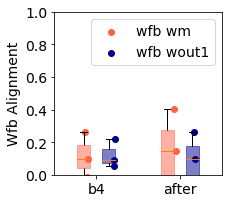

In [56]:
save = False
paper = False

c1 = 'tomato'
c2 = 'darkblue'

n = len(stats['corr_w_fb_w_m'])

""" alignment of w_fb and w_m """
fig,ax=plt.subplots(1,1,figsize=(3,3))
pos1 = 1
pos2 = 2
dx = 0.15
plt.scatter([pos1]*n+0.1*np.random.rand(n)-dx,np.asarray(stats['corr_w_fb_w_m'])[:,0],color=c1,label='wfb wm')
plt.scatter([pos2]*n+0.1*np.random.rand(n)-dx,np.asarray(stats['corr_w_fb_w_m'])[:,1],color=c1)
plt.scatter([pos1]*n+0.1*np.random.rand(n)+dx,np.asarray(stats['corr_w_fb_w_out'])[:,0],color=c2,label='wfb wout1')
plt.scatter([pos2]*n+0.1*np.random.rand(n)+dx,np.asarray(stats['corr_w_fb_w_out'])[:,1],color=c2)
plt.boxplot(np.asarray(stats['corr_w_fb_w_m']),positions=[pos1-dx,pos2-dx],patch_artist=True,boxprops=dict(facecolor=c1, color=c1,alpha=0.5))
plt.boxplot(np.asarray(stats['corr_w_fb_w_out']),positions=[pos1+dx,pos2+dx],patch_artist=True,boxprops=dict(facecolor=c2, color=c2,alpha=0.5))
plt.ylim([0,1])
plt.xlim([0.5,2.5])
ax.set_xticks([1,2])
ax.set_xticklabels(['b4','after'])
plt.legend()
plt.ylabel('Wfb Alignment')

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],ylim=[0,1],figsize=(2.5,2.5))

plt.show()

if save:
    fig.savefig(folder + 'rflo-align-boxplot-learn-wfb.pdf')


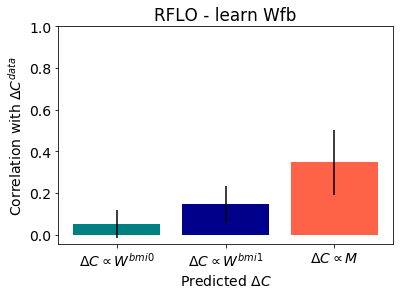

In [151]:
""" use covariance calculation to plot summary """
paper = False
save = False

fig,ax=plt.subplots(1,1)

""" take mean and std """
mn1 = np.mean(np.sum(np.asarray(stats['covariance1']),axis=2).squeeze()/task1.trial_duration)
mn2 = np.mean(np.sum(np.asarray(stats['covariance2']),axis=2).squeeze()/task1.trial_duration)
mn3 = np.mean(np.sum(np.asarray(stats['covariance3']),axis=2).squeeze()/task1.trial_duration)
std1 = np.std(np.sum(np.asarray(stats['covariance1']),axis=2).squeeze()/task1.trial_duration)
std2 = np.std(np.sum(np.asarray(stats['covariance2']),axis=2).squeeze()/task1.trial_duration)
std3 = np.std(np.sum(np.asarray(stats['covariance3']),axis=2).squeeze()/task1.trial_duration)

plt.bar([0,1,2],[mn1,mn2,mn3],yerr=[std1,std2,std3],tick_label=[r'$\Delta C \propto W^{bmi0}$',r'$\Delta C \propto W^{bmi1}$',r'$\Delta C \propto M$'],color=['teal','darkblue','tomato'])

plt.title('RFLO - learn Wfb')
plt.ylabel('Correlation with '+r'$\Delta C^{data}$')
plt.xlabel('Predicted '+r'$\Delta C$')
plt.ylim(top=1)

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],linewidth=2,ylim=[0,1],figsize=(2.5,2.5))

plt.show()

if save:

    fig.savefig(folder+'rflo-cov-learn-wfb.pdf')

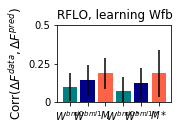

In [83]:
paper = True
save  = True

""" take mean and std """
mn1 = np.mean(np.asarray(stats['corr1']),axis=0)[0]
mn2 = np.mean(np.asarray(stats['corr2']),axis=0)[0]
mn3 = np.mean(np.asarray(stats['corr3']),axis=0)[0]
mn4 = np.mean(np.asarray(stats['corr4']),axis=0)[0]
mn5 = np.mean(np.asarray(stats['corr5']),axis=0)[0]
mn6 = np.mean(np.asarray(stats['corr6']),axis=0)[0]
std1 = np.std(np.asarray(stats['corr1']),axis=0)[0]
std2 = np.std(np.asarray(stats['corr2']),axis=0)[0]
std3 = np.std(np.asarray(stats['corr3']),axis=0)[0]
std4 = np.std(np.asarray(stats['corr4']),axis=0)[0]
std5 = np.std(np.asarray(stats['corr5']),axis=0)[0]
std6 = np.std(np.asarray(stats['corr6']),axis=0)[0]

fig,ax = plt.subplots(1,1)

plt.bar([0,1,2,3,4,5],[mn1,mn2,mn3,mn4,mn5,mn6],yerr=[std1,std2,std3,std4,std5,std6],
        tick_label=[r'$W^{bmi0}$',r'$W^{bmi1}$',r'$M$',r'$W^{bmi0*}$',r'$W^{bmi1*}$',r'$M*$'],
        color=['teal','darkblue','tomato','teal','darkblue','tomato'])      

plt.title('RFLO, learning Wfb')
plt.ylabel('Corr'+r'$(\Delta F^{data}, \Delta F^{pred})$') #with '+r'$\Delta F^{data}$
#plt.xlabel('Predicted '+r'$\Delta F$')
plt.ylim(top=0.5)

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.25,0.5,0.75,1],linewidth=2,ylim=[0,0.5],figsize=(2,2.75))

plt.show()

if save:
    fig.savefig(folder+'rflo-dF-learn-wfb-new-metric-all.pdf')

# REINFORCE with learning Wfb alone

In [ ]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,g_fb=2,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
rflo = RFLO(net0,apply_to=['w_rec','w_fb'],online=False)
sim0.run_session(n_trials=1000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Average over multiple seeds """
#seeds = [0,1,12,54] #,72,81]
seeds = [32,33,47]#,91,73,444,567,886,212]#,72,81,1973,1978,2002]
overlaps = [0.8]
overlap_w_out0 = 0.8
n_changes_w_out0 = 25
n_changes = [25]
training_duration = 10000

feedback_calculation = True
if feedback_calculation:
    print('FEEDBACK FLOWFIELD CALCULATION')

stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = []
stats['corr5'] = []
stats['corr6'] = []
stats['corrcoef'] = []

stats['corr_w_fb_w_m'] = []
stats['corr_w_fb_w_out'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corr5_list = []
    corr6_list = []
    corrcoef_list = []
    
    corr_w_fb_w_m = []
    corr_w_fb_w_out = []

    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_changes_w_out0,overlap=overlap_w_out0,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)
        w_m = choose_aligned_matrix(w_out1,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = w_m.T)

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = w_m.T)




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        
        corr_w_fb_w_m.append(np.corrcoef(net1_pre.w_fb.copy().ravel(),net1_pre.w_m.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)
        corr_w_fb_w_out.append(np.corrcoef(net1_pre.w_fb.copy().ravel(),net1_pre.w_out.T.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)

        
        """ Train with new decoder """

        sim1_train = Simulation(net1)
        reinforce = REINFORCE(net1,apply_to=['w_fb'],online=False,tau_reward=5)
        sim1_train.run_session(n_trials=training_duration, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','reward','err','pos'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy(),w_fb = net1.w_fb.copy())
        net1_post.set_weights(w_out = net1.w_out)
        net1_post.set_weights(w_m = net1.w_m)

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]
        pos_train = np.asarray(sim1_train.session_probes['pos'])[idx_train,:,:,:]

        
        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(w_m,err_train,h_train)
        
        if feedback_calculation:
            """ Take feedback into account with variation of metric """
            Fpred_w_out_fb = flow_field_predicted(net0.w_out,err_train,h_train,feedback=True,decoder=w_out1)
            Fpred_w_out1_fb = flow_field_predicted(w_out1,err_train,h_train,feedback=True,decoder=w_out1)
            Fpred_w_m_fb = flow_field_predicted(w_m,err_train,h_train,feedback=True,decoder=w_out1)

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        if feedback_calculation:
            """ Take feedback into account with variation of metric """
            corr4 = calculate_flow_field_correlation(Fpred_w_out_fb,Fdata,h_test) # could also sample sim_test
            corr4_list.append(corr4)

            corr5 = calculate_flow_field_correlation(Fpred_w_out1_fb,Fdata,h_test) # could also sample sim_test
            corr5_list.append(corr5)

            corr6 = calculate_flow_field_correlation(Fpred_w_m_fb,Fdata,h_test) # could also sample sim_test
            corr6_list.append(corr6)
        
        # correlation after learning
        corr_w_fb_w_m.append(np.corrcoef(net1.w_fb.copy().ravel(),net1.w_m.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)
        corr_w_fb_w_out.append(np.corrcoef(net1.w_fb.copy().ravel(),net1.w_out.T.copy().ravel())[0,1]) # w_fb and w_m both have dimensions (n_rec, n_out)

        
        fig,ax = plt.subplots(1,1)
        if feedback_calculation:
            plt.bar([0,1,2,3,4,5],[corr1,corr2,corr3,corr4,corr5,corr6],tick_label=['w_out0','w_out1','w_m','w_out0*','w_out1*','w_m*'],color=['teal','darkblue','tomato','teal','darkblue','tomato'])
        else:
            plt.bar([0,1,2],[corr1,corr2,corr3],tick_label=['w_out0','w_out1','w_m'],color=['teal','darkblue','tomato'])

        plt.ylim(top=1)
        plt.ylabel('Correlation dF')
        plt.title('Learn Wfb')
        plt.show()
        
        
        
        
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    stats['corr5'].append(corr5_list)
    stats['corr6'].append(corr6_list)
    #stats['corrcoef'].append(corrcoef_list)

    
    stats['corr_w_fb_w_m'].append(corr_w_fb_w_m)
    stats['corr_w_fb_w_out'].append(corr_w_fb_w_out)
